In [139]:
# A code for finding a reasonable value for the width of a gaussian using cross-validation.

from sklearn.cross_validation import KFold
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.grid_search import GridSearchCV
from sklearn import preprocessing

import time
import load_data
import plotting

% matplotlib inline
from matplotlib import pyplot as plt

In [140]:
def get_bins2(N,x_range,y_range):

    bins_x = np.linspace(x_range[0],x_range[1],N+1)
    bins_y = np.linspace(y_range[0],y_range[1],N+1)
    
    bin_centres_x = np.array([bins_x[B] + (bins_x[B+1]-bins_x[B])/2 for B in range(N)])
    bin_centres_y = np.array([bins_y[B] + (bins_y[B+1]-bins_y[B])/2 for B in range(N)])
    
    xx_centres,yy_centres =  np.meshgrid(bin_centres_x,bin_centres_y)
    xy = np.array([np.ravel(xx_centres),np.ravel(yy_centres)]).T # Used to 'score' the samples.
    
    return xy

In [141]:
def get_bins(N,x_range,y_range):

    bins_x = np.linspace(x_range[0],x_range[1],N+1)
    bins_y = np.linspace(y_range[0],y_range[1],N+1)
    
    bin_centres_x = np.array([bins_x[B] + (bins_x[B+1]-bins_x[B])/2 for B in range(N)])
    bin_centres_y = np.array([bins_y[B] + (bins_y[B+1]-bins_y[B])/2 for B in range(N)])
    
    xx,yy =  np.meshgrid(bins_x,bins_y)
    #xy = np.array([np.ravel(xx),np.ravel(yy)]).T 
    
    xx_centres,yy_centres =  np.meshgrid(bin_centres_x,bin_centres_y)
    xy = np.array([np.ravel(xx_centres),np.ravel(yy_centres)]).T # Used to 'score' the samples.
    
    return xx,yy,xx_centres,yy_centres,xy

In [267]:
def get_kde_bandwidth1(values,x_range=None,y_range=None,N=10,n_folds=15,num_sigmas=20,plot_values=False):

    xx,yy,xxc,yyc,xy = get_bins(x_range=x_range,y_range=y_range,N=N)
                   
    kf = KFold(n=len(values),n_folds=n_folds,shuffle=True)
    
    sigmas = np.logspace(-1,0.3,num_sigmas)
    chisq = np.zeros(num_sigmas)
    
    for train,test in kf:
    
        r = 0
    
        v_train,v_test = values[train],values[test]

        for sigma in sigmas:
    
            kde = KernelDensity(kernel='gaussian', bandwidth=sigma).fit(v_train)
        
            dens = np.exp(kde.score_samples(xy).reshape(N,N))
            train_dens = np.histogram2d(v_test[:,0],v_test[:,1],bins=N,
                range=[x_range,y_range],normed=True)[0]
            diff = np.sum((train_dens-dens)**2)
        
            chisq[r] = chisq[r] + [diff]
            r = r+1
    
    optimal_sigma = sigmas[np.argmin(chisq)]
    
    if plot_values:
        #plt.figure()
        #plt.plot(values[:,0], values[:,1] ,'.')
        #plt.show()

        plt.figure(1)
        plt.plot(sigmas,chisq,'k-')
        plt.xlabel('gaussian bandwidth')
        plt.ylabel('Total residual')
        plt.show()
        
    return optimal_sigma  

def get_kde_bandwidth2(values,x_range=None,y_range=None,N=10,n_folds=15,num_sigmas=20,plot_values=False):

    sigmas = np.logspace(-1,0.3,num_sigmas)

    kf = KFold(n=len(values),n_folds=n_folds,shuffle=True)
    params = {'bandwidth': sigmas}
    grid = GridSearchCV(KernelDensity(kernel='gaussian'), params, cv=kf)
    grid.fit(values)
    optimal_sigma = grid.best_estimator_.bandwidth
    gridscores = grid.grid_scores_
    
    chisq = np.zeros((num_sigmas,1))
    for r in range(50):
        chisq[r] = -gridscores[r][1]
    
    if plot_values:
        #plt.figure()
        #plt.plot(values[:,0], values[:,1] ,'.')
        #plt.show()


        plt.figure(1)
        plt.plot(sigmas,chisq,'r-')
        plt.xlabel('gaussian bandwidth')
        plt.ylabel('Total residual')
        plt.show()
        
    return optimal_sigma, grid

def get_kde_bandwidth3(values,x_range=None,y_range=None,N=10,n_folds=15,num_sigmas=20,plot_values=False):

    kf = KFold(n=len(values),n_folds=n_folds,shuffle=True)
    
    sigmas = np.logspace(-1,0.3,num_sigmas)
    chisq = np.zeros(num_sigmas)

    for train,test in kf:
    
        r = 0
    
        v_train,v_test = values[train],values[test]

        for sigma in sigmas:
    
            kde = KernelDensity(kernel='gaussian', bandwidth=sigma).fit(v_train)
        
            diff = -kde.score(v_test) / n_folds

            chisq[r] = chisq[r] + [diff]
            r = r+1
    
    optimal_sigma = sigmas[np.argmin(chisq)]
    
    if plot_values:
        #plt.figure()
        #plt.plot(values[:,0], values[:,1] ,'.')
        #plt.show()
    
        plt.figure(1)
        plt.plot(sigmas,chisq,'b-')
        plt.xlabel('gaussian bandwidth')
        plt.ylabel('Total residual')
        plt.show()
        
    return optimal_sigma 

In [268]:
def get_kde(values,x_range,y_range,bandwidth='optimal',N_out=100,print_bandwidth=False):
    
    if bandwidth == 'optimal':
        u = get_kde_bandwidth1(values=values,x_range=x_range,y_range=y_range,plot_values=True,
                              num_sigmas=50)
        if print_bandwidth:
            print("Optimised bandwidth from my 'method' = {0:0.2f}".format(u))
        
        u, grid = get_kde_bandwidth2(values=values,x_range=x_range,y_range=y_range,plot_values=True,
                              num_sigmas=50)
        
        if print_bandwidth:
            print("Optimised bandwidth from gridsearchCV = {0:0.2f}".format(u))

        u = get_kde_bandwidth3(values=values,x_range=x_range,y_range=y_range,plot_values=True,
                              num_sigmas=50)
        
        if print_bandwidth:
            print("Optimised bandwidth from likelihood = {0:0.2f}".format(u))

    else:
        u = bandwidth

    #xy = get_bins(N_out,x_range,y_range)
    
    xx,yy,xxc,yyc,xy = get_bins(x_range=x_range,y_range=y_range,N=N_out)
    
    kde = KernelDensity(kernel='gaussian', bandwidth=u).fit(values)
    dens = np.exp(kde.score_samples(xy).reshape(N_out,N_out))

    return dens, grid#,grid.grid_scores_

In [269]:
def sigma_hist(x,y,N_out=100,levels=[0.2,0.4,0.6,0.8],x_range=None,y_range=None,bandwidth='optimal'):
    
    values = np.array([x,y]).T # Read the x and y data into the correct format.
    
    # First set the x and y ranges if not done so already:
    if x_range == None:
        x_range = [np.min(values[:,0]),np.max(values[:,0])] 
    if y_range == None:
        y_range = [np.min(values[:,1]),np.max(values[:,1])]
      
    values = values[(values[:,0] >= x_range[0]) & (values[:,0] <= x_range[1])
        & (values[:,1] >= y_range[0]) & (values[:,1] <= y_range[1])]
    
    x, y = values.T
    
    # Get x and y grid values:
    X = np.linspace(x_range[0],x_range[1],N_out+1)
    Y = np.linspace(y_range[0],y_range[1],N_out+1)
    
    xx=np.linspace(x_range[0],x_range[1],N_out)
    yy=np.linspace(y_range[0],y_range[1],N_out)
    
    # Scale the appropriate values:
    values_scaled = preprocessing.scale(values)
    x_range_scaled = [(x_r-np.mean(x))*(1/np.std(x)) for x_r in x_range]
    y_range_scaled = [(y_r-np.mean(y))*(1/np.std(y)) for y_r in y_range]
    
    # Get 2d KDE values.    
    H, grid = get_kde(values=values_scaled,x_range=x_range_scaled
        ,y_range=y_range_scaled,print_bandwidth=True,bandwidth=bandwidth)
    
    # Rest is taken from the triangle.py method of plotting fractional data contours.
    #--------------------------------------------------------------------------------
    Hflat = H.flatten()
    inds = np.argsort(Hflat)[::-1]
    Hflat = Hflat[inds]
    sm = np.cumsum(Hflat)
    sm /= sm[-1]
    V = np.empty(len(levels))
    for i, v0 in enumerate(levels):
        try:
            V[i] = Hflat[sm <= v0][-1]
        except:
            V[i] = Hflat[0]

    # Compute the bin centers.
    X1, Y1 = 0.5 * (X[1:] + X[:-1]), 0.5 * (Y[1:] + Y[:-1])

    # Extend the array for the sake of the contours at the plot edges.
    H2 = H.min() + np.zeros((H.shape[0] + 4, H.shape[1] + 4))
    H2[2:-2, 2:-2] = H
    H2[2:-2, 1] = H[:, 0]
    H2[2:-2, -2] = H[:, -1]
    H2[1, 2:-2] = H[0]
    H2[-2, 2:-2] = H[-1]
    H2[1, 1] = H[0, 0]
    H2[1, -2] = H[0, -1]
    H2[-2, 1] = H[-1, 0]
    H2[-2, -2] = H[-1, -1]
    X2 = np.concatenate([
        X1[0] + np.array([-2, -1]) * np.diff(X1[:2]),
        X1,
        X1[-1] + np.array([1, 2]) * np.diff(X1[-2:]),
    ])
    Y2 = np.concatenate([
        Y1[0] + np.array([-2, -1]) * np.diff(Y1[:2]),
        Y1,
        Y1[-1] + np.array([1, 2]) * np.diff(Y1[-2:]),
    ])

    #H2 = H2.T
    #--------------------------------------------------------------------------------
    return X2,Y2,H2,V, grid#,gridscores

In [270]:
x = np.random.randn(500) + 2
y = 1*(np.random.randn(500)) + 1 + 0.5*x
y[::10] = 3*np.random.randn(500//10)-1
x[1::200] = 4*np.random.randn(500//150) + 10
y[1::200] += 2*np.random.randn(500//150)
s = np.argsort(x)
x = x[s]
y = y[s]

xrng = [-3, 14]
yrng = [-14, 8]

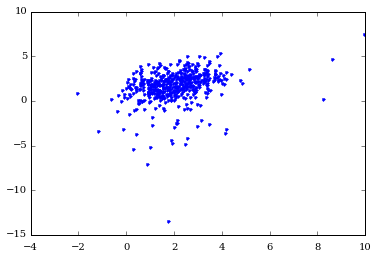

In [271]:
plt.plot(x, y, '.')

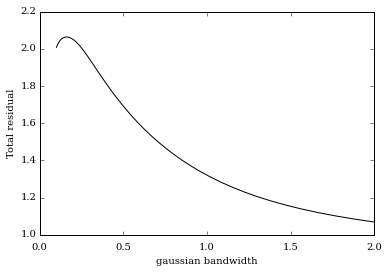

Optimised bandwidth from my 'method' = 2.00


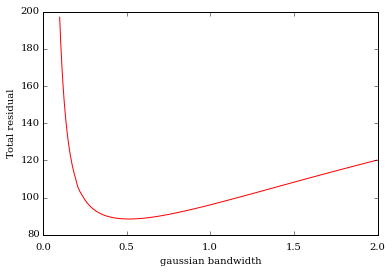

Optimised bandwidth from gridsearchCV = 0.52


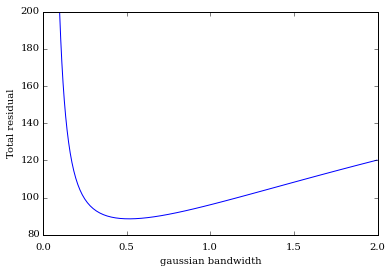

Optimised bandwidth from likelihood = 0.52


In [272]:
x2,y2,h2,v2, grid = sigma_hist(x,y,x_range=xrng,y_range=yrng)

#plt.subplot(111,aspect='equal')
#plt.contour(x2,y2,h2,v2,colors='k',levels=v2)

In [273]:
# Try the contour method w. some real data

cx=['PETROMAG_MU','PETROMAG_MR']
cy=['PETROMAG_MR','PETROMAG_MZ']

t,ft = load_data.load(cx=cx,cy=cy,p_th=0.5,N_th=5,norm=False,p_values='d')
b,t = load_data.assign(table=
                       
                       t,Nb=20,th=0.5,equal_samples=False,redistribute=False
                       ,rd_th=0,ct_th=0,print_sizes=True)

t_r = t[b[:,1] == 4]
    
x = t_r[:,-1]
y = t_r[:,-2]

total sample: 12136
total 'assigned' sample: 7641
m = 1: 93
m = 2: 4454
m = 3: 998
m = 4: 423
m = 5: 460
m = 6: 1213


In [274]:
xrng = [1,6]
yrng = [-0.6,1.5]

#xrng = [1,3.5]
#yrng = [-0.4,0.75]

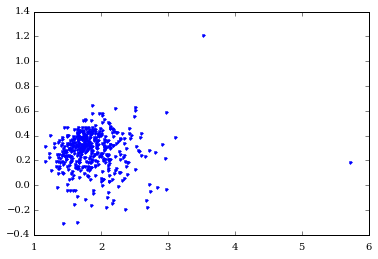

In [275]:
plt.plot(x, y, '.')

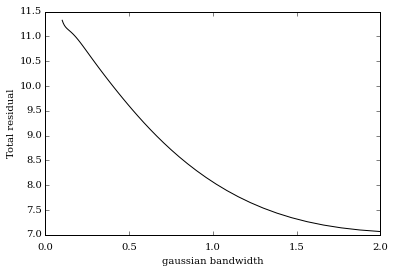

Optimised bandwidth from my 'method' = 2.00


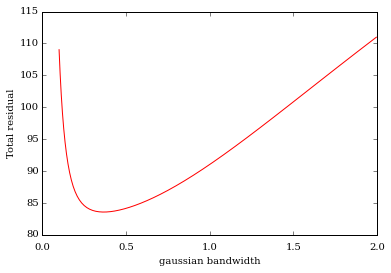

Optimised bandwidth from gridsearchCV = 0.36


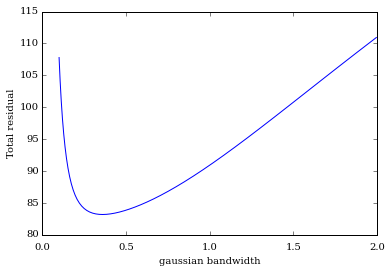

Optimised bandwidth from likelihood = 0.36


In [276]:
ok = (x>1) & (x < 3.5) & (y > -0.5) & (y < 0.8)
x = x[ok]
y = y[ok]
x2,y2,h2,v2, grid = sigma_hist(x=x,y=y)#,x_range=xrng,y_range=yrng)

<matplotlib.contour.QuadContourSet instance at 0x11a78e560>

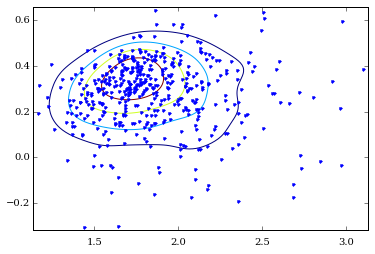

In [277]:
plt.plot(x, y, '.')
plt.contour(x2,y2,h2,v2)

In [278]:
grid.grid_scores_

[mean: -109.02718, std: 27.85029, params: {'bandwidth': 0.10000000000000001},
 mean: -105.24362, std: 24.93547, params: {'bandwidth': 0.10629935081760272},
 mean: -101.96148, std: 22.36404, params: {'bandwidth': 0.11299551984243776},
 mean: -99.11671, std: 20.09485, params: {'bandwidth': 0.12011350404548685},
 mean: -96.65374, std: 18.09196, params: {'bandwidth': 0.12767987504462749},
 mean: -94.52445, std: 16.32406, params: {'bandwidth': 0.13572287829716537},
 mean: -92.68715, std: 14.76405, params: {'bandwidth': 0.14427253854085181},
 mean: -91.10571, std: 13.38851, params: {'bandwidth': 0.15336077187700115},
 mean: -89.74863, std: 12.17715, params: {'bandwidth': 0.16302150491411688},
 mean: -88.58834, std: 11.11227, params: {'bandwidth': 0.17329080141679257},
 mean: -87.60060, std: 10.17829, params: {'bandwidth': 0.18420699693267165},
 mean: -86.76402, std: 9.36131, params: {'bandwidth': 0.19581084190003126},
 mean: -86.05977, std: 8.64870, params: {'bandwidth': 0.20814565377021571}